
### *Mathis DO BARREIRO Gregory DORN Alexiane BORAZ*
---

# **MACHINE LEARNING PROJECT : Automobile insurance claims**

**Problem : Predicting the Final Cost of an Automobile Insurance Claim**

Objective of the project :



# PROBELMATIQUE:
## How to design a robust and interpretable machine learning regression model capable of accurately predicting the ultimate incurred claim cost of motor insurance claims ?

#1. Environment Setup and Data Loading ( Step 1)

In [ ]:
# Importing essential libraries and tools
# We explain why we use those librairies in the sources section
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint, uniform

# Loading, displaying and configuring datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("Training set shape:", train_df.shape) # the goal is to see the number of lines and columns in our dataset for a first vision
print("Test set shape:", test_df.shape)
np.random.seed(42) # to fix the random seed in order to get the same result every time
pd.set_option("display.max_columns", None)# we show all columns to better view the data
sns.set_style("whitegrid")# style of the graphics


Training set shape: (54000, 15)
Test set shape: (36000, 14)
Training set shape: (54000, 15)
Test set shape: (36000, 14)


***Sources used for the imports :***
- for the use of the libraries LightGBM and SciPy, it is chatgpt that advised us to use them
- for the rest of the librairies, we see them in our courses

- pandas : Pandas is used for data manipulation and analysis.
It allows loading CSV files, inspecting datasets, cleaning columns, and transforming data efficiently.

- NumPy : NumPy is the foundation of numerical computing in Python.
It supports mathematical operations, numerical arrays, and reproducibility through

- Matplotlib : visualisation libraries

- Scikit-learn : Used for splitting the dataset, evaluating models with cross-validation, and tuning hyperparameters.

- LightGBM Python API : A high-performance gradient boosting framework.

- SciPy stats : These functions provide probability distributions for hyperparameter tuning in RandomizedSearchCV.


#2. Exploratory Data Analysis (EDA) (Step 2 : Data Analysis)

2.1. Data inspection

In [ ]:
# Display information about the training dataset
print("Training dataset information:")
train_df.info() # display a resume of the dataset
categorical_cols = train_df.select_dtypes(include='object').columns # Identify categorical columns
print("Number of unique categories per categorical variable:")
for col in categorical_cols: # We iterate through each categorical column selected
    uniq = train_df[col].nunique()
    print(f"- {col}: {uniq} unique values")#For each column, we print the number of unique values.


Training dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ClaimNumber                54000 non-null  object 
 1   DateTimeOfAccident         54000 non-null  object 
 2   DateReported               54000 non-null  object 
 3   Age                        54000 non-null  int64  
 4   Gender                     54000 non-null  object 
 5   MaritalStatus              53971 non-null  object 
 6   DependentChildren          54000 non-null  int64  
 7   DependentsOther            54000 non-null  int64  
 8   WeeklyWages                54000 non-null  float64
 9   PartTimeFullTime           54000 non-null  object 
 10  HoursWorkedPerWeek         54000 non-null  float64
 11  DaysWorkedPerWeek          54000 non-null  int64  
 12  ClaimDescription           54000 non-null  object 
 13  InitialIncurredC

***Sources :***
- pandas Documenntation for the df ( dataframe) inspection
- Kaggle tutorials
- Scikit-learn Documentation

***Why are we doing this ?***
In our dataset, some columns contain text values instead of numbers. These are called categorical variables. It's like ( yes or no, male or female, source of the accident etc...)
The machine learning algorithms cannot work with this type of data so we identify categorical variables so we can convert them into numbers, which is required for any Machine Learning model to function.


2.2. Analyze of the target values

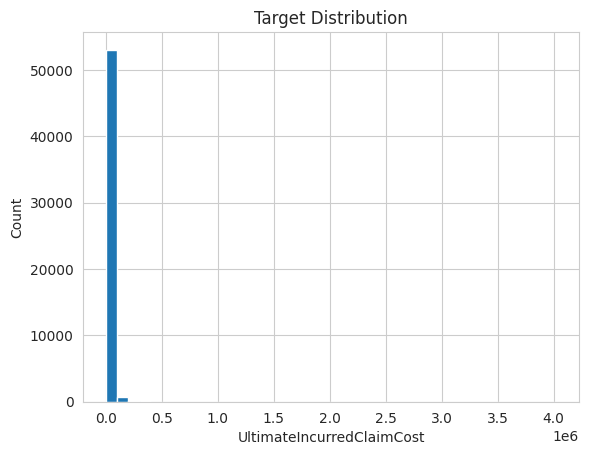

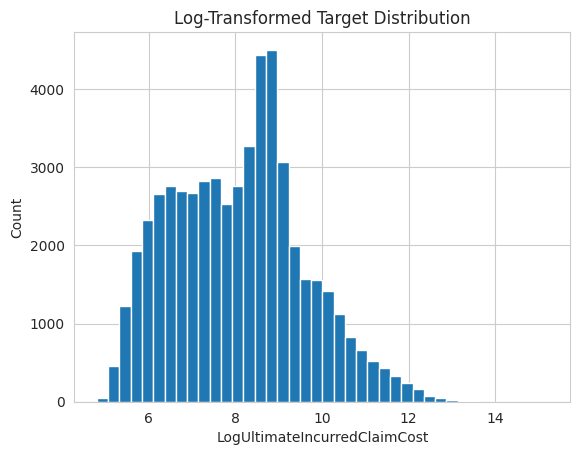

In [ ]:
# We Plot the distribution of the target values
plt.hist(train_df["UltimateIncurredClaimCost"], bins=40)# we choose an histogram
plt.title("Target Distribution") # title of the plot
plt.xlabel("UltimateIncurredClaimCost")# title in x
plt.ylabel("Count")# title in y
plt.show()# we display the plot

# We apply a log transformation to better see
train_df["LogUltimateIncurredClaimCost"] = np.log1p(train_df["UltimateIncurredClaimCost"])

# We Plot the distribution after the log transformation
# Our objectif here is to see a better model perfromance
# we reduce the impact of the outliers also called extreme values and make the relationship more linear
plt.hist(train_df["LogUltimateIncurredClaimCost"], bins=40)
plt.title("Log-Transformed Target Distribution")
plt.xlabel("LogUltimateIncurredClaimCost")
plt.ylabel("Count")
plt.show()


***Sources:***

- For the basic plotting, we just know how to do it, we learn it in class same for the log transformation.

***Why are we doing this?***

We first plot the histogram of the raw target variable to observe how the claim costs are distributed.
Our first histogram shows that a few claims are extremely expensive compared to the rest.

For this reason, we apply a log transformation to the target variable in order to reduce the influence of outliers and make the distribution more symmetrical. Then we plot thi log version


2.3. Analyze of the missing values

In [ ]:
# Function to check missing values in our dataset

# We create the function check_missing_values to see the NaN
def check_missing_values(df):
    missing = df.isnull().sum() # we count the missing values in each columns
    missing = missing[missing > 0]# We don't take the column with 0 missing values
    percentage = (missing / len(df)) * 100 #we calcule the percentage of missing values in each columns
    missing_info = pd.DataFrame({
        "Count": missing,
        "Percentage": percentage
    })
    return missing_info
# We print the missing values of our dataset to see them
print("Missing values in Train:")
print(check_missing_values(train_df))
print("Missing values in Test:")
print(check_missing_values(test_df))


Missing values in Train:
               Count  Percentage
MaritalStatus     29    0.053704
Missing values in Test:
               Count  Percentage
MaritalStatus     18        0.05


***Sources :***
- Pandas Documentation : for detecting missing values using isnull and sum
- Kaggle EDA Tutorials : standard practice for checking missing values in datasets

***Why are we doing this ? ***

This part is important in a machine learning project. It is very important to clean the data before using it.
We check for missing values to understand the quality of our dataset and to identify which columns may require cleaning before training a model.
Then we decicde if we remove a column or no

2.4. Analyze of the correlation

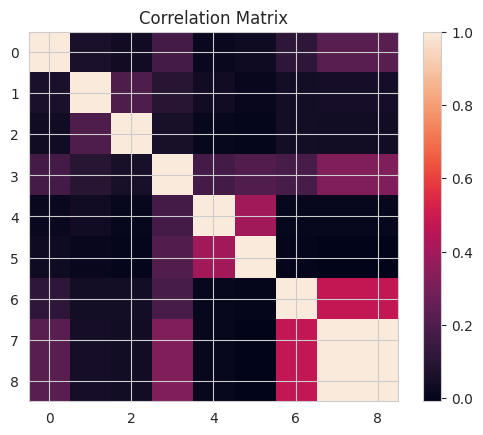

In [ ]:
#we create the correlation matrix
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()# We take all the columns that contains numbers
numeric_features = [col for col in numeric_cols if col not in ['UltimateIncurredClaimCost', 'ClaimNumber']]# we remove two useless columns
correlation_matrix = train_df[numeric_features + ['LogUltimateIncurredClaimCost']].corr()# we calculate the correlation matrix
plt.imshow(correlation_matrix)
plt.colorbar()
plt.title("Correlation Matrix")
plt.show()




***Sources***

- matplotlib documentation, nothing else

***Why are we doint this ?***

In class, we learned the concept of correlation between numerical variables, but we did not learn how to visualize a correlation matrix.
So we first do a first version of the correlation matrix xith matplotlib

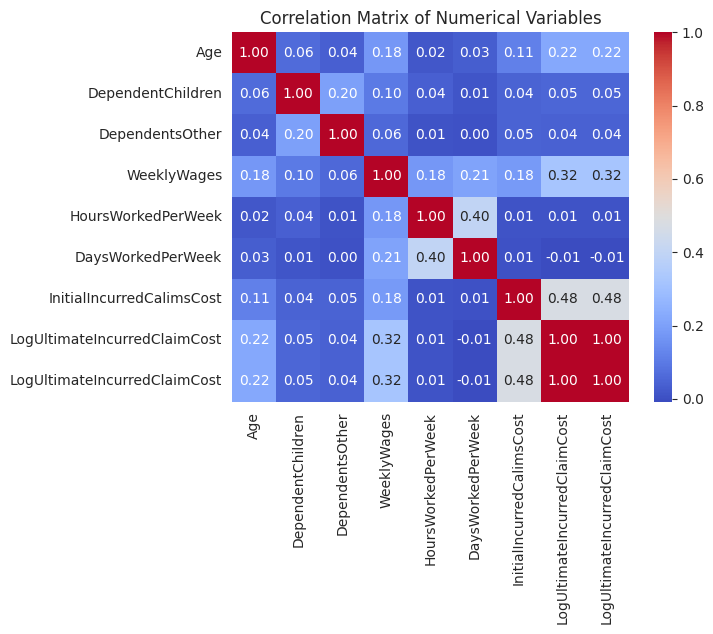

In [ ]:
#we create the correlation matrix
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()# We take all the columns that contains numbers
numeric_features = [col for col in numeric_cols if col not in ['UltimateIncurredClaimCost', 'ClaimNumber']]# we remove two useless columns
correlation_matrix = train_df[numeric_features + ['LogUltimateIncurredClaimCost']].corr()# we calculate the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()


Then we decided to do another version with the heatmap to have a more visualisable correlation matrix.

***Sources :***
- Seaborn Documentation :
The documentation explains how to visualize a correlation matrix using colormaps.

***Why are we doing this ?***

The objective here is to quickly identify which variables are most strongly correlated with each other. The heatmap helps us visualize these relationships thanks to the colors and the values.



 ***Key Analysis (Insurance Domain Assumptions):***

We observe the highestcorrelation between InitialIncurredClaimsCost and UltimateIncurredClaimsCost.
The higher the initial cost of the claim, the higher the final cost will be. This will be our most powerful predictor.

Other Numerical Features: Variables such as Age, WeeklyWages, or HoursWorkedPerWeek will generally have weaker correlations, but even a low coefficient ($|r| > 0.1$) can be relevant.

2.6. Temporal Analysis of Claim Frequency

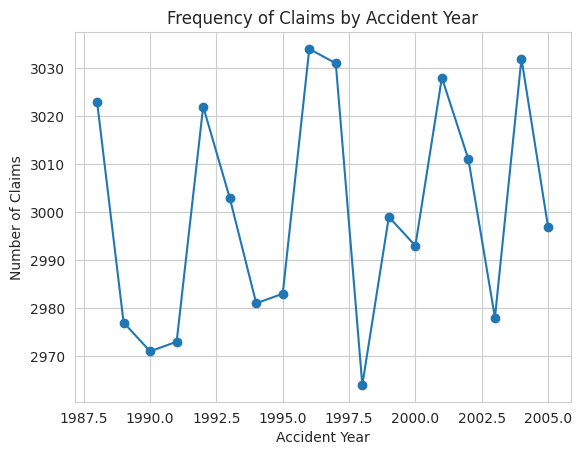

/tmp/ipython-input-2255303031.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='AccidentMonth', y='LogUltimateIncurredClaimCost', data=train_df, palette='viridis')


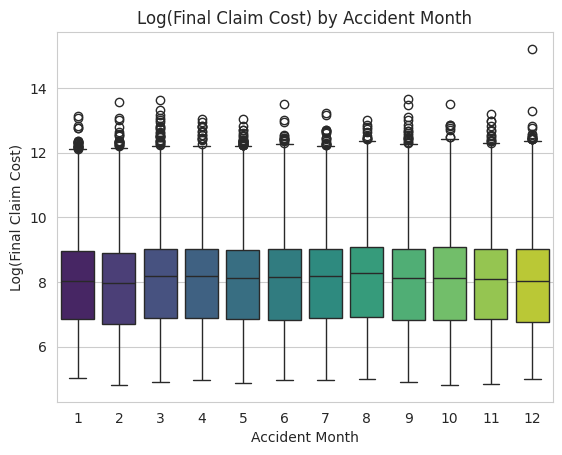

In [ ]:
# Extracting Temporal Features from the Accident Date
train_df['DateTimeOfAccident'] = pd.to_datetime(train_df['DateTimeOfAccident'], errors='coerce')
train_df['AccidentYear'] = train_df['DateTimeOfAccident'].dt.year
train_df['AccidentMonth'] = train_df['DateTimeOfAccident'].dt.month

# Plot of frequency of Claims by Accident Year
train_df.groupby('AccidentYear').size().plot(kind='line', marker='o')# the o marker is to plot th epoint on the graph
plt.title('Frequency of Claims by Accident Year')
plt.xlabel('Accident Year')
plt.ylabel('Number of Claims')
plt.show()

# plot of log(Final Claim Cost) by Accident Month
sns.boxplot(x='AccidentMonth', y='LogUltimateIncurredClaimCost', data=train_df, palette='viridis')
plt.title('Log(Final Claim Cost) by Accident Month')
plt.xlabel('Accident Month')
plt.ylabel('Log(Final Claim Cost)')
plt.show()



***Sources***
- pandas
- matplotlib ( first plot)
- for the boxplot we use the seaborn documentation, we add palette='viridis'to have beautiful colors in our model


***Why are we doing this ?***
The boxplot helps us visualize how the (log-transformed) claim cost behaves across different months. It makes it easier to identify potential seasonality


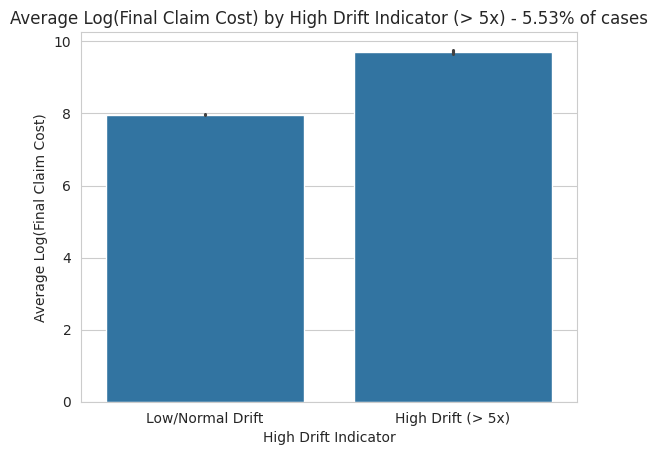

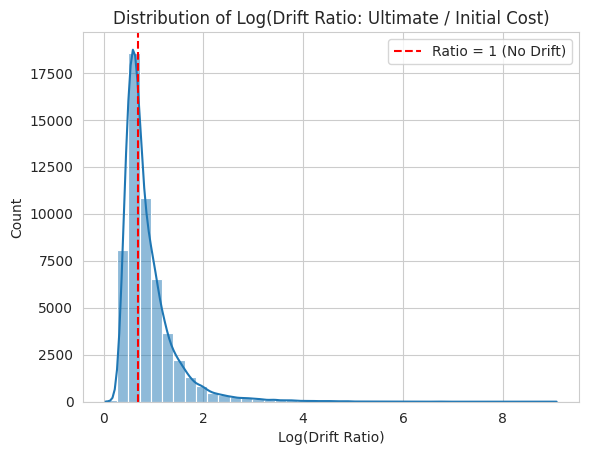


Proportion of underestimated claims (Ratio > 1): 53.96%
Proportion of overestimated claims (Ratio < 1): 46.04%


In [ ]:
# Drift Analysis: Relationship between Initial and Ultimate Incurred Claim Cost

if "LogUltimateIncurredClaimCost" not in train_df.columns:
    train_df["LogUltimateIncurredClaimCost"] = np.log1p(train_df["UltimateIncurredClaimCost"])
train_df_drift = train_df[train_df["InitialIncurredCalimsCost"] > 0].copy() # Keep only claims with a positive initial incurred cost
train_df_drift["Drift_Ratio"] = (
    train_df_drift["UltimateIncurredClaimCost"] / train_df_drift["InitialIncurredCalimsCost"] # Create the Drift Ratio: Ultimate cost / Initial estimated cost
)

# Define a high drift indicator (1 if Drift_Ratio > 5, else 0)
train_df_drift["High_Drift"] = (train_df_drift["Drift_Ratio"] > 5).astype(int)
high_drift_percent = train_df_drift["High_Drift"].mean() * 100
# Average log(final claim cost) by high drift indicator
sns.barplot(
    x="High_Drift",
    y="LogUltimateIncurredClaimCost",
    data=train_df_drift
)
# We plot the average log
plt.title(f"Average Log(Final Claim Cost) by High Drift Indicator (> 5x) - {high_drift_percent:.2f}% of cases")
plt.xticks([0, 1], ["Low/Normal Drift", "High Drift (> 5x)"])
plt.xlabel("High Drift Indicator")
plt.ylabel("Average Log(Final Claim Cost)")
plt.show()
# We plot the distribution of the log drift ratio
sns.histplot(np.log1p(train_df_drift["Drift_Ratio"]), bins=40, kde=True)
plt.axvline(x=np.log1p(1), color="red", linestyle="--", label="Ratio = 1 (No Drift)")
plt.title("Distribution of Log(Drift Ratio: Ultimate / Initial Cost)")
plt.xlabel("Log(Drift Ratio)")
plt.legend()
plt.show()

# Proportion of underestimated and overestimated claims
print(f"\nProportion of underestimated claims (Ratio > 1): {(train_df_drift['Drift_Ratio'] > 1).mean() * 100:.2f}%")
print(f"Proportion of overestimated claims (Ratio < 1): {(train_df_drift['Drift_Ratio'] < 1).mean() * 100:.2f}%")


This is one of the most specific and important analyses in claims provisioning. The Drift Rate measures the difference between the initial estimate and the actual final cost.

A ratio > 1 indicates an underestimation (the final cost is higher than the estimate). A ratio < 1 indicates an overestimation. The objective of the model is to predict this ratio or to incorporate the factors that explain its variation.

#3. Feature Engineering and Pre-processing (Step 2)

3.1. Feature Engineering

In [ ]:
def apply_feature_engineering(df):
    # Create a copy to avoid modifying the original DataFrame
    data_copy = df.copy()

    # Convert date columns to datetime format

    data_copy['DateTimeOfAccident'] = pd.to_datetime(data_copy['DateTimeOfAccident'], errors='coerce')
    data_copy['DateReported'] = pd.to_datetime(data_copy['DateReported'], errors='coerce')

    # Calculate reporting delay in days
    # Using total_seconds() then converting - there's probably a cleaner way but this works
    data_copy['Delay_Reported_Days'] = (data_copy['DateReported'] - data_copy['DateTimeOfAccident']).dt.total_seconds() / (60*60*24)

    # Handle negative delays (data entry errors probably)
    median_delay_value = data_copy[data_copy['Delay_Reported_Days'] >= 0]['Delay_Reported_Days'].median()

    # Fix the weird negative values
    data_copy.loc[data_copy['Delay_Reported_Days'] < 0, 'Delay_Reported_Days'] = median_delay_value
    data_copy['Delay_Reported_Days'] = data_copy['Delay_Reported_Days'].fillna(median_delay_value)

    # Extract date features - these usually help with seasonality patterns
    data_copy['AccidentYear'] = data_copy['DateTimeOfAccident'].dt.year
    data_copy['AccidentMonth'] = data_copy['DateTimeOfAccident'].dt.month
    data_copy['AccidentDayOfWeek'] = data_copy['DateTimeOfAccident'].dt.dayofweek  # 0=Monday

    # Simple text feature - just counting characters for now
    # Note: could do more sophisticated NLP later but keeping it simple
    data_copy['ClaimDescriptionLength'] = data_copy['ClaimDescription'].apply(lambda x: len(str(x)))

    # Clean up - remove the original date columns since we extracted what we need
    columns_to_drop = ['DateTimeOfAccident', 'DateReported', 'ClaimDescription']
    data_copy = data_copy.drop(columns=columns_to_drop, errors='ignore')

    return data_copy

In this section, we transform raw insurance claim data into features that can be used by an ML algorithm to predict the final cost of claims.


1) Cleaning → Converting dates to the correct format
2) Creation → Calculating the reporting delay (days between accident and report)
3) Extraction → Retrieval of the year, month and day of the week of the accident
4) Simplification → Measurement of the length of the claim description
5) Cleaning → Removal of columns that are no longer needed



3.2. Pre-processing Pipeline

In [ ]:
# we apply the "feature_engineering" to train and test data
train_df_processed = apply_feature_engineering(train_df)
test_df_processed = apply_feature_engineering(test_df)

# Ensure LogUltimateIncurredClaimCost is present in train_df_processed
# This line ensures the target variable (log-transformed) is available for splitting,
# in case it was not carried over correctly by apply_feature_engineering.
if 'UltimateIncurredClaimCost' in train_df_processed.columns and 'LogUltimateIncurredClaimCost' not in train_df_processed.columns:
    train_df_processed['LogUltimateIncurredClaimCost'] = np.log1p(train_df_processed['UltimateIncurredClaimCost'])

# Separate the features (X) and the target (y) for training
X_train = train_df_processed.drop(columns=['UltimateIncurredClaimCost', 'LogUltimateIncurredClaimCost', 'ClaimNumber'])
y_train_log = train_df_processed['LogUltimateIncurredClaimCost']
X_test = test_df_processed.drop(columns=['ClaimNumber'])

# Separation of column types for pre-processing
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Defining pre-processing strategies
numerical_transformer = Pipeline(steps=[

    # Median imputation for missing values
    ('imputer', SimpleImputer(strategy='median')),

    # Scaling to standardise numerical variables
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    # Imputation par la valeur la plus fréquente (mode)
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Encodage One-Hot pour les variables catégorielles
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Creation of the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print(" ColumnTransformer has been successfully defined.")

 ColumnTransformer has been successfully defined.


The apply_feature_engineering() function is applied to the train_df and test_df dataframes.
This creates two new processed dataframes: train_df_processed and test_df_processed.
We then identify the numerical and categorical columns, and
define the transformations to be applied; we then assemble  all these transformations into a ColumnTransformer
The preprocessor automatically applies:
the numerical pipeline to numerical columns
the categorical pipeline to categorical columns
And it passes the other columns through (‘passthrough’)

#4.Implementation of Standard Solutions (Step 2)

4.0. Preparation and Metrics

In [ ]:
# We create an evaluation function for regression models trained on log-transformed targets
def evaluate_model(model, X, y):
    y_pred_log = model.predict(X)  # Predictions on the log scale
    y_true_orig = np.expm1(y)    # Convert both true and predicted values back to the original scale
    y_pred_orig = np.expm1(y_pred_log)
    y_pred_orig[y_pred_orig < 0] = 0 # We want to make sure predicted costs are not negative
    mse = mean_squared_error(y_true_orig, y_pred_orig) # Compute regression metrics on the original scale
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_orig, y_pred_orig)
    return {
        "RMSE (euros)": rmse,
        "MSE (euros^2)": mse,
        "R2": r2
    }
print("Evaluation function is defined")


Evaluation function is defined


***SOURCES***

- NumPy documentation : for the reverse of the log1p transfromation applied to the target variable
- ChatGPT guidance
Helped structure the evaluation function and ensure metrics were computed after reversing the log transformation, as this specific point was not explicitly covered in class.

***Why are we doing this ? ***

Most claim cost variables are highly skewed, so we train our models on a log-transformed version of the target to stabilize the distribution.
However, evaluation must be done on the original scale (euros) because RMSE and MSE have no real meaning on the log scale.

###Part A: Regression Task (Predicting the Ultimate Claim Cost)

4.2. Model 1: Linear Regression (Baseline)

In [ ]:
# Model use: Linear Regression
# We build the pipeline for Linear Regression
lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),  # ColumnTransformer defined earlier
    ("regressor", LinearRegression())
])
print("Linear Regression")
# Train and validation split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_log, test_size=0.2, random_state=42
)
lr_pipeline.fit(X_train_split, y_train_split)
lr_metrics = evaluate_model(lr_pipeline, X_val_split, y_val_split) # We evaluate the validation split
print("Performance on the validation set (original scale):")
print(f"Validation RMSE: {lr_metrics['RMSE (euros)']:.2f}")
print(f"Validation MSE: {lr_metrics['MSE (euros^2)']:.2f}")
print(f"Validation R2: {lr_metrics['R2']:.4f}")
# Cross-validation to check strengh
cv_scores = cross_val_score(
    lr_pipeline,
    X_train,
    y_train_log,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
cv_rmse = np.sqrt(-cv_scores)
print(f"RMSE on the log scale: {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")

Linear Regression
Performance on the validation set (original scale):
Validation RMSE: 7146758894669.15
Validation MSE: 51076162698532660283703296.00
Validation R2: -56260119484868768.0000
RMSE on the log scale: 1.2632 (+/- 0.0618)


***SOURCES***

Sources used for the Linear Regression baseline model:

- Scikit-learn Documentation : LinearRegression

***Why are we doing this ?***

Linear Regression is used as our baseline model because it is simple, fast to train, and easy to interpret. It's our reference to compare to the more advanced models


ANALYSIS:

The results obtained on the original scale (in Euros) are extremely poor and unusable. The value of our negative and astronomically low $R^2$ ($-5.6 \times 10^{16}$) means that our model is billions of times worse than simply predicting the average cost.

This is the typical and expected result when using Linear Regression on a highly skewed target variable full of outliers (such as insurance costs), even after logarithmic transformation.

###Part B: Classification Task (Using Classification Algorithms)


4.2. Preparation for Classification

In [ ]:
# We define the threshold: 75th percentile of the ultimate claim cost
threshold = train_df["UltimateIncurredClaimCost"].quantile(0.75)
print("\n--- Preparation for the Classification Task ---")
print(f"High cost threshold (75th percentile): {threshold:.2f} euros")
y_train_class = (train_df["UltimateIncurredClaimCost"] >= threshold).astype(int)
# Train/validation split for the classification task (with stratification)
X_train_class, X_val_class, y_train_class_split, y_val_class_split = train_test_split(
    X_train,
    y_train_class,
    test_size=0.2,
    random_state=42,
    stratify=y_train_class
)
print(f"Class ratio in the validation set, 1 = high cost): {y_val_class_split.mean():.2f}")



--- Preparation for the Classification Task ---
High cost threshold (75th percentile): 8197.25 euros
Class ratio in the validation set, 1 = high cost): 0.25


***Sources***
- pandas documentation : for computing the 75 th percentile

- Scikit-learn : for the train test split xith the stratify

- kaggle models : to help us for creating the binary target based on the treshold


***Why are we doing this ?***

For this part we make the classification. We take all the claims of the 75th percentile. The claims with a 1 are the hight cost claims and others (0) are the normal cost claims.
This allows us to train classification models to predict if a claim is likely to be high-cost rather than predicting the exact amount.

4.3. Model 2: Logistic Regression (Classification)

In [ ]:
# Logistic Regression pipeline for the classification task
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(random_state=42))
])
print("Model 2: Logistic Regression (with the classification(75th percentile))")

logreg_pipeline.fit(X_train_class, y_train_class_split)
y_pred_logreg = logreg_pipeline.predict(X_val_class)
accuracy_logreg = accuracy_score(y_val_class_split, y_pred_logreg)
print(f"Validation Accuracy: {accuracy_logreg:.4f}")
print("\nClassification Report:")# report of the classification
print(classification_report(
    y_val_class_split,
    y_pred_logreg,
    target_names=["Low Cost", "High Cost"]
))


Model 2: Logistic Regression (with the classification(75th percentile))
Validation Accuracy: 0.9068

Classification Report:
              precision    recall  f1-score   support

    Low Cost       0.92      0.96      0.94      8100
   High Cost       0.87      0.74      0.80      2700

    accuracy                           0.91     10800
   macro avg       0.89      0.85      0.87     10800
weighted avg       0.90      0.91      0.90     10800



***Sources :***

- same that for the classification part


***Analysis:***

This approach involves transforming the regression problem (predicting the exact cost) into a binary classification problem (predicting whether the cost will be ‘High’ or ‘Low’) using the 75th percentile as the threshold. This is a very relevant strategy in insurance for making quick decisions.

The model correctly classified approximately 91% of the claims in the validation set as either ‘Low Cost’ or ‘High Cost’.

A. *Low Cost*

**class Precision 0.92:** When the model predicts a claim as Low Cost, it is correct 92% of the time.

**Recall 0.96** The model identified 96% of all claims that were actually Low Cost.

**F1-Score 0.94:** Very good balance between Precision and Recall.

**Support 8100**: The Low Cost class is the most numerous in the validation set.



B. *High Cost class (Minority and Critical)*

**Precision  :  0.87**,  When the model predicts a claim as High Cost, it is correct 87% of the time. This is excellent: 13% of predictions are false alarms (false positives).

**Recall    0.74**    This is the weak point: the model only identified 74% of all claims that were actually High Cost. This means that 26% of High Cost claims were missed (false negatives).

**F1-Score    0.80**    Acceptable, but indicates that the balance is not as good as for the Low Cost class.

**Support    2700 **   The High Cost class represents 25% of the data (2700 / 10800), confirming a class imbalance problem (8100 vs 2700).

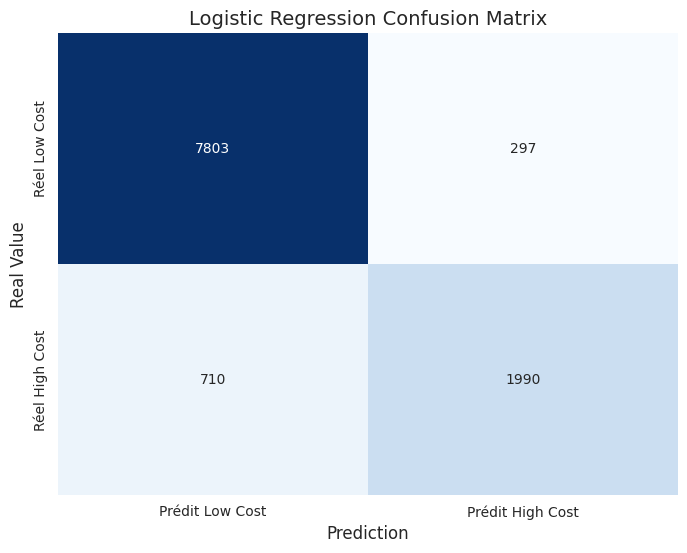

In [ ]:
# Calcul of Confusion Matrix
cm = confusion_matrix(y_val_class_split, y_pred_logreg)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    cbar=False,
    xticklabels=["Prédit Low Cost", "Prédit High Cost"],
    yticklabels=["Réel Low Cost", "Réel High Cost"]
)
plt.title('Logistic Regression Confusion Matrix', fontsize=14)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Real Value', fontsize=12)
plt.show()

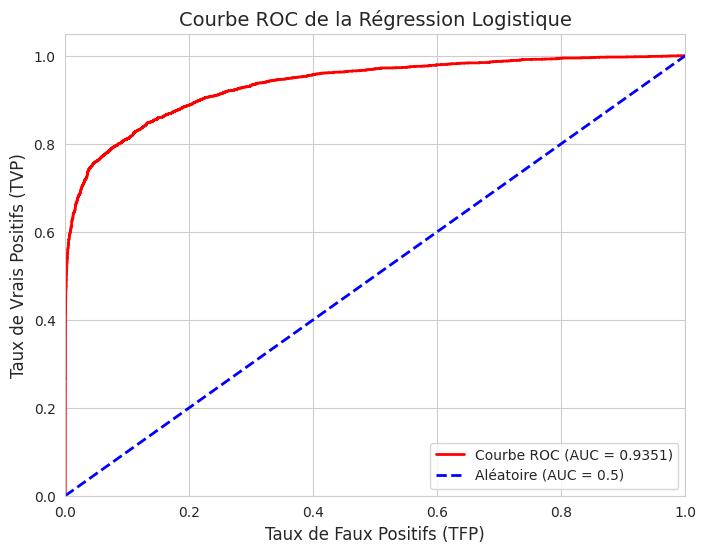

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score



y_proba_logreg = logreg_pipeline.predict_proba(X_val_class)[:, 1]

#  Calcul of True Positive (TVP) and False Positive (TFP)
fpr, tpr, thresholds = roc_curve(y_val_class_split, y_proba_logreg)

#  Calcul of AUC
auc_score = roc_auc_score(y_val_class_split, y_proba_logreg)

#  PLOT
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'Courbe ROC (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Aléatoire (AUC = 0.5)') # Ligne de référence
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (TFP)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TVP)', fontsize=12)
plt.title('Courbe ROC de la Régression Logistique', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


4.4. Model 3: Naive Bayes (Classification)

In [ ]:
# Naive Bayes pipeline for the classification task
nb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", GaussianNB())
])
print("Model 3: Naive Bayes (using classification)")
nb_pipeline.fit(X_train_class, y_train_class_split)
y_pred_nb = nb_pipeline.predict(X_val_class)
accuracy_nb = accuracy_score(y_val_class_split, y_pred_nb)
print(f"Validation Accuracy: {accuracy_nb:.4f}")
print("\nClassification Report:")# report of the classification
print(classification_report(
    y_val_class_split,
    y_pred_nb,
    target_names=["Low Cost", "High Cost"]
))


Model 3: Naive Bayes (using classification)
Validation Accuracy: 0.8659

Classification Report:
              precision    recall  f1-score   support

    Low Cost       0.89      0.94      0.91      8100
   High Cost       0.78      0.64      0.70      2700

    accuracy                           0.87     10800
   macro avg       0.84      0.79      0.81     10800
weighted avg       0.86      0.87      0.86     10800



***Sources***:
- Scikit-learn Documentation : implementation of the naive bayes on numerical data

***Why are we doing this ?***
Naive Bayes is used here as a baseline classifier to compare with Logistic Regression.
We use the same processor and the same split as for logistic regression to compare the models better.

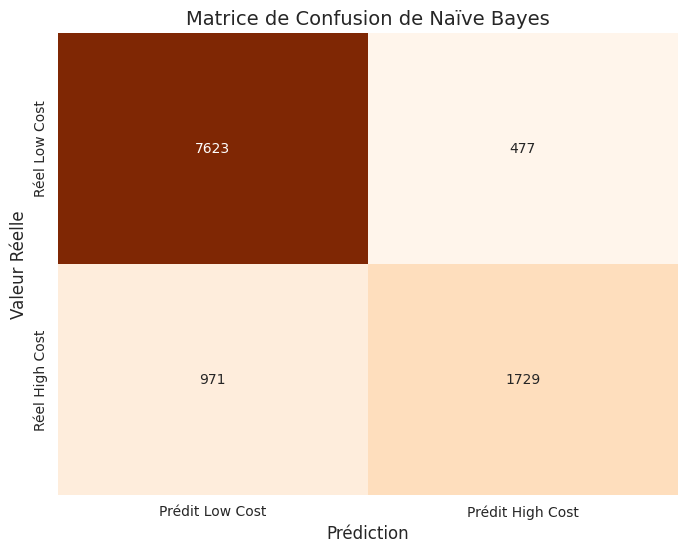

In [ ]:
cm_nb = confusion_matrix(y_val_class_split, y_pred_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt='d',
    cmap='Oranges',
    cbar=False,
    xticklabels=["Prédit Low Cost", "Prédit High Cost"],
    yticklabels=["Réel Low Cost", "Réel High Cost"]
)
plt.title('Matrice de Confusion de Naïve Bayes', fontsize=14)
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Valeur Réelle', fontsize=12)
plt.show()

In [ ]:
# --- Preparation of the binary target (high-cost claims) ---
threshold = train_df["UltimateIncurredClaimCost"].quantile(0.75)
y_train_class = (train_df["UltimateIncurredClaimCost"] >= threshold).astype(int)
X_train_class, X_val_class, y_train_split_class, y_val_split_class = train_test_split(
    X_train,
    y_train_class,
    test_size=0.2,
    random_state=42,
    stratify=y_train_class
)
logreg_pipeline = Pipeline(steps=[#model logistic regression
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(random_state=42))
])
logreg_pipeline.fit(X_train_class, y_train_split_class)
y_pred_logreg = logreg_pipeline.predict(X_val_class)

print("Model 2: Logistic Regression (High-Cost Claims)")
print(f"Validation Accuracy: {accuracy_score(y_val_split_class, y_pred_logreg):.4f}")
print("Classification Report:\n", classification_report(y_val_split_class, y_pred_logreg, target_names=["Low Cost", "High Cost"]))
nb_pipeline = Pipeline(steps=[# model naive bayes
    ("preprocessor", preprocessor),
    ("classifier", GaussianNB())
])
nb_pipeline.fit(X_train_class, y_train_split_class)
y_pred_nb = nb_pipeline.predict(X_val_class)

print(" Model 3: Naive Bayes (High-Cost Claims)")
print(f"Validation Accuracy: {accuracy_score(y_val_split_class, y_pred_nb):.4f}")
print("Classification Report:\n", classification_report(y_val_split_class, y_pred_nb, target_names=["Low Cost", "High Cost"]))




Model 2: Logistic Regression (High-Cost Claims)
Validation Accuracy: 0.9068
Classification Report:
               precision    recall  f1-score   support

    Low Cost       0.92      0.96      0.94      8100
   High Cost       0.87      0.74      0.80      2700

    accuracy                           0.91     10800
   macro avg       0.89      0.85      0.87     10800
weighted avg       0.90      0.91      0.90     10800

 Model 3: Naive Bayes (High-Cost Claims)
Validation Accuracy: 0.8659
Classification Report:
               precision    recall  f1-score   support

    Low Cost       0.89      0.94      0.91      8100
   High Cost       0.78      0.64      0.70      2700

    accuracy                           0.87     10800
   macro avg       0.84      0.79      0.81     10800
weighted avg       0.86      0.87      0.86     10800



***sources :*** same as native bayes and logistic regression
- Seaborn heatmap to visualize the confusion matrix


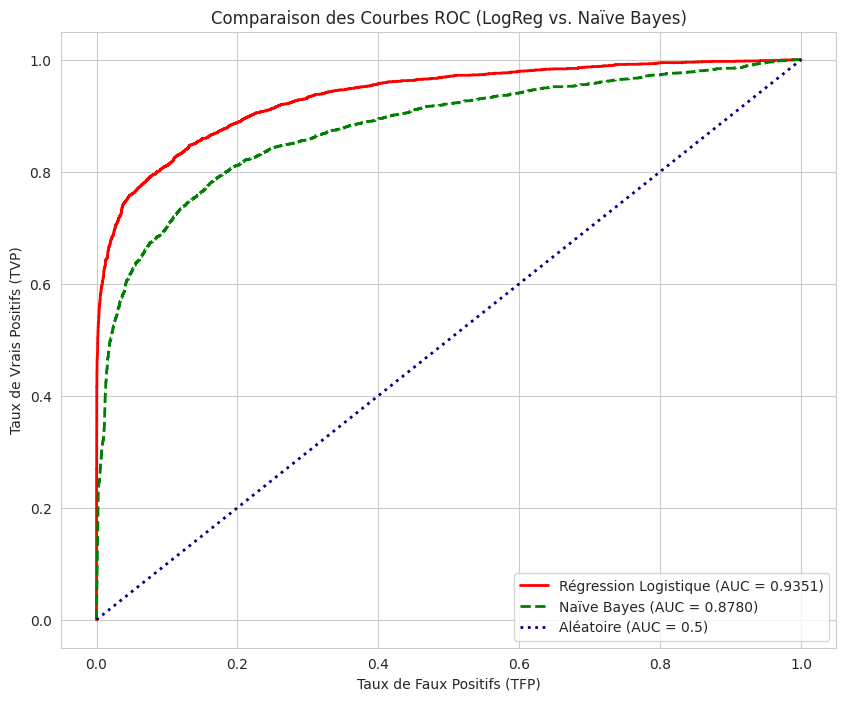

In [ ]:


# Calculate y_proba_nb
y_proba_nb = nb_pipeline.predict_proba(X_val_class)[:, 1]

# Calculate le TTP et TFP for the 2 models
fpr_logreg, tpr_logreg, _ = roc_curve(y_val_class_split, y_proba_logreg)
fpr_nb, tpr_nb, _ = roc_curve(y_val_class_split, y_proba_nb)

# Calculate the AUC
auc_logreg = roc_auc_score(y_val_class_split, y_proba_logreg)
auc_nb = roc_auc_score(y_val_class_split, y_proba_nb)

# plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_logreg, tpr_logreg, color='red', lw=2, label=f'Régression Logistique (AUC = {auc_logreg:.4f})')
plt.plot(fpr_nb, tpr_nb, color='green', lw=2, linestyle='--', label=f'Naïve Bayes (AUC = {auc_nb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':', label='Aléatoire (AUC = 0.5)')

plt.xlabel('Taux de Faux Positifs (TFP)')
plt.ylabel('Taux de Vrais Positifs (TVP)')
plt.title('Comparaison des Courbes ROC (LogReg vs. Naïve Bayes)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

A quick conclusion about the 3 models:

Regression Task: Linear Regression failed because it cannot handle complex relationships and outliers.

Classification Task: Logistic Regression is good, but the Recall for the ‘High Cost’ class is insufficient (74%).

Naive Bayes: Less effective than Logistic.

## 5. Improvement and Advanced Model (Step 3)

5.1. Advanced Model: LightGBM


Evaluation function defined.

--- Model 3: LightGBM (Advanced) ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1136
[LightGBM] [Info] Number of data points in the train set: 43200, number of used features: 19
[LightGBM] [Info] Start training from score 8.120345


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Validation RMSE (euros): 26240.37
Validation MSE  (euros^2): 688556999.92
Validation R2: 0.2416


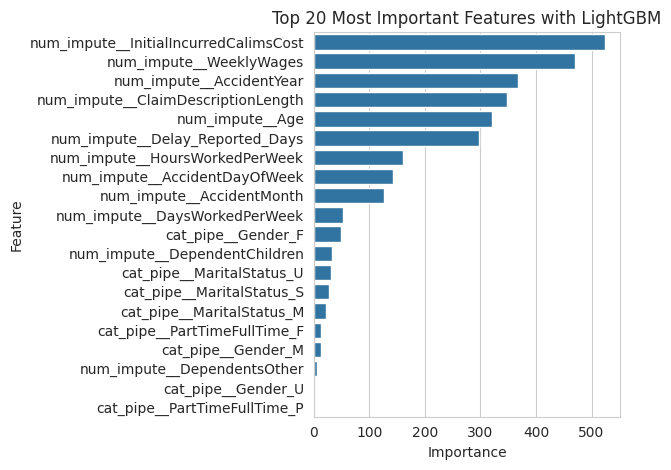

In [ ]:
# Evaluation function
def evaluate_model(model, X, y):
    y_pred_log = model.predict(X)
    y_true_orig = np.expm1(y) # Convert both true and predicted values back to the original euro scale
    y_pred_orig = np.expm1(y_pred_log)
    y_pred_orig[y_pred_orig < 0] = 0
    # Compute regression metrics on the original scale
    mse = mean_squared_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_orig, y_pred_orig)
    return {
        "RMSE (euros)": rmse,
        "MSE (euros^2)": mse,
        "R2": r2
    }
print("Evaluation function defined.")

# 5.1 Advanced Model: LightGBM Regressor
# Preprocessing for LightGBM: imputation + encoding, no scaling needed
lgbm_preprocessor = ColumnTransformer(
    transformers=[
        ("num_impute", SimpleImputer(strategy="median"), numerical_features),
        ("cat_pipe", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features)
    ],
    remainder="passthrough"
)

# LightGBM pipeline
lgbm_pipeline = Pipeline(steps=[
    ("preprocessor", lgbm_preprocessor),
    ("regressor", lgb.LGBMRegressor(
        objective="regression_l1",
        metric="mae",
        random_state=42,
        n_jobs=-1
    ))
])

print("\n--- Model 3: LightGBM (Advanced) ---")

# Train the model on the training split (log-transformed target: y_train_split)
lgbm_pipeline.fit(X_train_split, y_train_split)
lgbm_metrics = evaluate_model(lgbm_pipeline, X_val_split, y_val_split)
print(f"Validation RMSE (euros): {lgbm_metrics['RMSE (euros)']:.2f}")
print(f"Validation MSE  (euros^2): {lgbm_metrics['MSE (euros^2)']:.2f}")
print(f"Validation R2: {lgbm_metrics['R2']:.4f}")

# Feature Importance Plot for LightGBM
lgbm_reg = lgbm_pipeline.named_steps["regressor"]
importances = lgbm_reg.feature_importances_
feature_names = lgbm_pipeline.named_steps["preprocessor"].get_feature_names_out()
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# We Plot the top 20 most important features
sns.barplot(data=fi_df.head(20), x="Importance", y="Feature")
plt.title("Top 20 Most Important Features with LightGBM")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

